# Repetition code for up to 15 qubits

James R. Wootton, University of Basel

***
## 1 - Introduction


The aim of this study is to look at the properties of the repetion code when run using the 16 qubit *ibmqx3* device.

The repetition code is a classical error correcting code, with which a collection of noisy bits can be used to store a bit value with arbitrarily low noise.

The code can also be interpreted as a quantum error correcting code, in which the noisy bits are replaced by noisy qubits. Such a code can be used to store a *bit* with arbitrarily low noise. However, due to the limited set of errors that can be detected and corrected, it cannot fully protect a *qubit*.

Despite this fact, the repetition code based on qubits nevertheless uses the same resources and techniques as other quantum codes. It can therefore serve as a prelimary test of quantum error correction. An introduction to these concepts for a general audience can be found [here](http://decodoku.blogspot.ch/2016/01/what-is-error-correction-what-is.html).

Until now, the most extensive experiments of quantum repetition codes were implemented a few years ago by the team at Google/UCSB.

[J. Kelly et al., Nature **519**, *66–69* (2015)](https://www.nature.com/nature/journal/v519/n7541/full/nature14270.html)

The largest repetition code in this experiment used 5 qubits to store data (we call these *code qubits*), and an additional 4 *ancilla qubits* to mediate measurements. In this notebook we will use the 16 qubit device *ibmqx3* to implement codes of a variety of sizes, including some larger than those in the Google/UCSB experiment.

The number of code qubits in our experiments will be denoted *d*. The number of ancilla qubits in a repetition code is always *d-1*, one less than that of code qubits.

We will also use an additional qubit that is not part of the code, to compare storing a bit in a code with storing it in a single qubit. The total number of qubits needed is therefore *2d*. We will consider codes for *d=3...8*.

In each case we will do a single round of ancilla-assisted syndrome measurement followed by direct measurement of all qubits. This allows us to read out the value of the stored bit, as well as clues about errors that it may have suffered. Using this information, we can try to correct for the effects of the errors and recover the original value of the stored bit. By looking at how often this process succeeds, we will be able to see how well the system implements quantum error correction.

The conditions under which we will declare the system as able to successfully implement the repetion code will be those set out in,

[J. R. Wootton, A. Peter, J. R. Winkler, D. Loss, arXiv:1608.05053 (2016)](https://arxiv.org/abs/1608.05053).

In the program, the qubits in the register are labelled according to their address on the chip. The information can be found [here](https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx3).

    1---2---3---4---5   6---7---8
    |       |   |   |   |   |   |
    0--15--14--13--12--11--10---9

Lines in this diagram denote the possibility of a CNOT between the corresponding qubits.

Qubits in the repetition code alternate between code and ancilla qubits. The single qubit is placed at the end of the line. For the case of d=8, the layout of these qubits will be as follows.

    c2--a1--c1--a0--c0   s--c7--a6
     |       |   |   |   |   |   |
    a2--c3--a3--c4--a4--c5--a5--c6
 
The address of code qubit c$n$ therefore $(5-2n)$%$16$.

The address of ancilla qubit a$n$ is $(4-2n)$%$16$.

***

## 2 - Set Up

First we set up things required to run things using QISKit, and on the Quantum Experience.

Set up intructions can be found in the [IBM SDK](https://github.com/IBM/qiskit-sdk-py/blob/master/tutorial/sections/tutorial4developer.ipynb).

For more information about how to use the IBM Quantum experience, check out the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), and the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

In [1]:
import sys
sys.path.append("../../")
from qiskit import QuantumProgram
import Qconfig

Next we import a few standard things.

In [2]:
import random, numpy, math

***
## 3 - Functions

The running of jobs and processing of data is handled by the following functions.

### *AddError*

Though our aim is to run on a real quantum device, a simulator can be used to make sure all is working as it should. There will be no errors in this case, so we will have to add in some fake ones.

This function checks whether a simulator is being used. If so, it adds a rotation around the x axis as a stand-in for errors.

The rotation chosen depends on the bit value stored in the code. The angle of rotation for stored *0* is half that for *1*. The reason is that realistic noise in the device has a bias towards transitions from *1* to *0*. Our choice of rotations serves as a simplistic way to obtain similar behaviour.

In [3]:
def AddError (script,q,num,simulator,bit):
    
    # errors are rotations around the x axis by a fraction of pi
    # this fraction is twice as large for qubits initially in state 1
    
    fracAncilla = 0.05
    
    fracCode = fracAncilla
    if (bit==1):
        fracCode = fracCode*2

    
    # if the code is simulated add these rotations for error like effects
    if (simulator):
        for address in range(0,num-1,2): # code qubits
            script.u3(fracCode * math.pi, 0.0, 0.0, q[address])
        for address in range(1,num-1,2): # ancilla qubits
            script.u3(fracAncilla * math.pi, 0.0, 0.0, q[address])
        script.u3(fracCode * math.pi, 0.0, 0.0, q[num-1]) # single qubit
                
        script.barrier()

### *AddCnot*

The input specifies control and target qubits for a CNOT gates.

The function implements the CNOT if it is allowed by the device used. If the CNOT is not directly possible, but one with control and target interchanged can be done, conjugation by Hadamards is performed. Otherwise it will print an error.

For a simulator, all things are possible.

In [4]:
def AddCnot(repetitionScript,q,control,target,simulator):
    
    # set the coupling map ()
    # b in coupling_map[a] means a CNOT with control qubit a and target qubit b can be implemented
    # note that is is not just copy and pasted from https://github.com/IBM/qiskit-qx-info/tree/master/backends/ibmqx3
    coupling_map = {0: [1], 1: [2], 2: [3], 3: [14], 4: [3, 5], 5: [], 6: [7, 11], 7: [10], 8: [7], 9: [10, 8], 10:[], 11: [10], 12: [5, 11, 13], 13: [4, 14], 14:[], 15: [0, 14]}
    
    # if such a CNOT is directly possible, we do it
    if ( target in coupling_map[control] or simulator):
        repetitionScript.cx(q[control], q[target])
    # if it can be done the other way round we conjugate with Hadamards
    elif ( control in coupling_map[target] ):
        repetitionScript.h(q[control])
        repetitionScript.h(q[target])
        repetitionScript.cx(q[target], q[control])
        repetitionScript.h(q[control])
        repetitionScript.h(q[target])
    else:
        print('Qubits ' + str(control) + ' and ' + str(target) + ' cannot be entangled.')

### *GetAddress*

Given a code qubit specified by input *codeQubit* this function gives the address of that qubit in the register. For the ancillas either side, use an offset of *+1* or *-1*.

For *codeQubit=0* only *offset=1* gives a valid ancilla. For *codeQubit=d-1* (the last one) *offset=-1* gives the last ancilla and *offset=1* gives the single qubit.

For a simulator we don't bother with the coupling graph, so things are different and simpler.

In [5]:
def GetAddress (codeQubit,offset,simulator):
    
    if (simulator):
        address = 2*codeQubit + offset
    else:
        address = (5-2*codeQubit-offset)%16
    
    return address

### *RunRepetition*

This function takes a specification for a repetition code, runs it and then returns the result.

Inputs:

* *bit* - Bit value to be stored in the repetition code. If it is not *1*, it will be treated as *0*.
    
* *d* - Number of code qubits

* *device* - The backend device on which the job will be run. This should be 'ibmqx3', 'local_qasm_simulator' or 'ibmqx_qasm_simulator'.

Output:

* *results* - Dictionary with bit strings as keys and the fraction of times that result occurred as values.

In [6]:
def RunRepetition(bit,d,device):
    
    # set the number of shots to use on the backend
    shots = 8192
    
    # determine whether a simulator is used
    simulator = (device!='ibmqx3')
    
    # if the simulator is used, we declare the minimum number of qubits required
    if (simulator):
        num = 2*d
    # for the real device there are always 16
    else:
        num = 16
    
    # create a dictionary with the specifications of the program
    Q_SPECS = {
        "circuits": [{
            "name": "repetitionScript",
            "quantum_registers": [{
                "name": "q",
                "size": num
            }],
            "classical_registers": [{
                "name": "c",
                "size": num
            }]}],
    }

    # create the program with these specs
    Q_program = QuantumProgram(specs=Q_SPECS)

    # get the circuit by name
    repetitionScript = Q_program.get_circuit("repetitionScript")
    # get the quantum register by name
    q = Q_program.get_quantum_registers("q")
    # get the classical register by name
    c = Q_program.get_classical_registers("c")
    
    # now we insert all the quantum gates to be applied
    # a barrier is inserted between each section of the code to prevent the complilation doing things we don't want it to
    
    # the stored bit is initialized by repeating it accross all code qubits same state
    # since qubits are automatically initialized as 0, we just need to do Xs if b=1
    if (bit==1):
        for codeQubit in range(d):
            repetitionScript.x( q[GetAddress(codeQubit,0,simulator)] )
        # also do it for the single qubit on the end for comparision
        repetitionScript.x( q[GetAddress(d-1,1,simulator)] )
       
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # we then start the syndrome measurements by doing CNOTs between each code qubit and the next ancilla along the line
    for codeQubit in range(d-1):
        AddCnot(repetitionScript,q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,1,simulator),simulator)
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # next we perform CNOTs between each code qubit and the previous ancilla along the line
    for codeQubit in range(1,d):
        AddCnot(repetitionScript,q,GetAddress(codeQubit,0,simulator),GetAddress(codeQubit,-1,simulator),simulator)
    repetitionScript.barrier()
    
    # if the code is simulated add rotations for error like effects (and a barrier)
    AddError(repetitionScript,q,num,simulator,bit)
    
    # all qubits are then measured
    for address in range(num):
        repetitionScript.measure(q[address], c[address])
        
    # set the APIToken and API url
    Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"])
    
    # run the job until actual results are given
    dataNeeded = True
    while dataNeeded:
    
        # run job
        Q_program.execute(["repetitionScript"], device, shots, max_credits=5, wait=10, timeout=500)

        # to see what the quantum computer is asked to do, we can print the QASM file
        # these lines are typically commented out
        #compiled_qasm = Q_program.get_compiled_qasm("repetitionScript")
        #print('\nCompiled QASM for d = ' + str(d) +' and bit = ' + str(bit) + '\n')
        #print(compiled_qasm)

        # extract data
        results = Q_program.get_counts("repetitionScript")
        
        # see if it really is data
        if ('status' not in results.keys()):
            dataNeeded = False
        
    
    # the raw data states the number of runs for which each outcome occurred
    # we convert this to fractions before output.
    for key in results.keys():
        results[key] = results[key]/shots
    
    # return the results
    return results

### *AddProbToResults*

The inputs are a probability *prob* for a given bit string *string* that is to be added to a dictionary *results*. The probability is added to the previous value for that bit string if it exists.

In [7]:
def AddProbToResults(prob,string,results):
    
    if string not in results.keys():
        results[string] = 0
    
    results[string] += prob
    

### *CalculateError*

The job of this function is to determine the total probability that the decoding fails when the encoded bit value is that specified by the input *bit*, given the look up table in *results*. The way in which this is done is depends on the decoding procedure, which we will now explain.

The decoder uses lookup tables, given by the input *results*. This is a pair of dictionaries, one for each possible value of the encoded bit, with bit strings as keys and probabilties of the form

$$result[encodedBit][string] = P(\,string\,|\,encodedBit\,)$$.

Suppose the decoder were to receive an output *string* from a single run of the code with unknown initial value. The goal is then to deduce the most likely value of the encoded bit. This can be done using

$$P(\,encodedBit\,|\,string\,) = \frac{P(\,string\,|\,encodedBit\,) \,\times\, P(\,encodedBit\,)}{P(\,string\,|\,0\,) + P(\,string\,|\,1)\,}.$$

Assuming $P(\,encodedBit\,)=0.5$, with no bias towards *0* or *1*, $P(\,encodedBit\,|\,string\,)$ is simply proportional to $P(\,string\,|\,encodedBit\,)$. We can therefore decode by simply looking at which lookup table has the highest value for *string*. The corresponding encoded bit value is taken to be *decodedBit*, the value that the decoder assumes it that of the encoded bit.

For example, consider a *d=3* code for which we only look at the output from the code qubits. Given a simple error model, we might expect results of the following form when *encodedBit=0*.

    result[0] = 
    {'000': 0.669, '001': 0.1, '010': 0.1, '100': 0.1, '110': 0.01, '101': 0.01, '011':0.01, '111':0.001}

Similarly for *encodedBit=1*

    result[1] = 
    {'000':0.001, '001': 0.01, '010': 0.01, '100':0.01, '110': 0.1, '101': 0.1, '011': 0.1, '111': 0.669}

Now suppose that at readout time, and with no idea what the encoded bit was, we find the result *'001'*. From the lookup tables we see that this result would occur with probability *0.1* for *encodedBit=0* and *0.01* for *encodedBit=1*. We should therefore take *decodedBit = 0*.

Note that we have not taken the usual step of ignoring the logical readout, and focussing only on the abstract syndrome. Though it usually makes things simpler, it would just make things harder in this case.

Note also that the lookup tables are populated by experimental data, and so decoding will suffer from numerical innacuracies when the sample size is too small.


In [8]:
def CalculateError (bit,results):
    
    # total prob of error will be caculated by looping over all strings
    # we initialize the value to 0
    error = 0
    
    # all strings that have results for the given encoded bit are looped over
    for string in results[bit].keys():

        # the probability P(string|bit) is extracted
        right = results[bit][string]
        
        # as is the probability P(string|!bit)
        # if there is no result for this value in the table, the prob is 0
        wrong = 0
        if string in results[(bit+1)%2].keys():
            wrong = results[(bit+1)%2][string]

        # if this is a string for which P(string|!bit)>P(string|bit), the decoding fails
        # the probabilty P(string|bit) is then added to the error
        if (wrong>right):
            error += right
        # if P(string|!bit)=P(string|bit), the decoder randomly chooses between them
        # P(failure|string) is therefore 0.5 in this case
        elif (wrong==right):
            error += 0.5*right
        # otherwise the decoding succeeds, and we don't care about that
            
    return error

### *GetData*

For a given code distance *d* and backend *device*, this function determines the probability of error for both possible encoded bit values. Results are printed to screen when *verbose=True*.

The probability of a bit flip on the stored bit will be determined for each possible value of the stored bit for three cases.

* *Full Code* - This will use all available data in the decoding, including results from both code qubits and ancilla qubits.

* *Code Qubits Only* - This will ignore the results of the ancilla assisted measurements.

* *Single Qubit* - This is for a bit stored in a single qubit over the same timescale.

The results are returned in the outputs *errorFull*, *errorCode* and *errorSingle*, respectively, which are dictionaries with the encoded bit values *0* and *1* as keys and the probability of a readout error after decoding as the value.

In [9]:
def GetData(d,device,verbose):
    
    # determine whether a simulator is used
    simulator = (device!='ibmqx3')
    
    # we are going to fill a bunch of dictionaries with results
    # each of the following is a list of two dictionaries, with one for each value for the stored bit
    resultsRaw = [{},{}] # the results that come fresh from the backend
    resultsFull = [{},{}] # the results from the full code (including ancillas)
    resultsCode = [{},{}] # the same but with ancilla results excluded
    resultsSingle = [{},{}] # results for a similar bit stored on a single qubit
    
    # for both possible values of the stored bit
    for bit in [0,1]:
        
        # run the job and put results in resultsRaw
        resultsRaw[bit] = RunRepetition(bit,d,device)
        
        # loop over all keys in the raw results and look at the ones without strings as values
        # since all such entries should have a bit string as a key, we call it stringRaw
        for stringRaw in resultsRaw[bit].keys():
            if resultsRaw[bit][stringRaw] is not str:
                     
                bitNum = len(stringRaw)-1
                
                # extract the bit string relevant for resultsFull
                # from left to right this will alternate between code and ancilla qubits in increasing order
                stringFull = ''
                for codeQubit in range(d):
                    stringFull += stringRaw[bitNum-GetAddress(codeQubit,0,simulator)]
                    if (codeQubit!=(d-1)):
                        stringFull += stringRaw[bitNum-GetAddress(codeQubit,1,simulator)]
                
                # remove ancilla bits from this to get the string for resultsCode
                stringCode = ""
                for n in range(d):
                    stringCode += stringFull[2*n]
                    
                # extract the bit of the single qubit memory for resultsCode
                stringSingle = stringRaw[bitNum-GetAddress(d-1,1,simulator)]
                
                # in each case, add the corresponding result in resultsRaw to the other results
                probToAdd = resultsRaw[bit][stringRaw]
                
                AddProbToResults(probToAdd,stringFull,resultsFull[bit])
                AddProbToResults(probToAdd,stringCode,resultsCode[bit])
                AddProbToResults(probToAdd,stringSingle,resultsSingle[bit])
    
    
    # the probability that the decoding fails is calculated for the three cases (full code, code qubits only and single qubit)
    # these are the outputs
    errorFull = [0,0]
    errorCode = [0,0]
    errorSingle = [0,0]
    
    for bit in [0,1]:
        
        errorFull[bit] = CalculateError(bit,resultsFull)
        errorCode[bit] = CalculateError(bit,resultsCode)
        errorSingle[bit] = CalculateError(bit,resultsSingle)
        
    # for those times when we want to stare into the depths of the results
    if (verbose):
        for bit in [0,1]:
            displayDict = {}
            for stringFull in resultsFull[bit]:
                # set up the display string
                # this is just a reordered full string, with all code qubits followed by all ancilla qubits
                displayString = ""
                # first the code ones
                for n in range(d):
                    displayString += stringFull[2*n]
                # copy to stringCode
                stringCode = displayString
                # then add a gap
                displayString += " "
                # and continue to the ancilla ones
                for n in range(d-1):
                    displayString += stringFull[2*n+1] 
                # store the results for that string in a dictionary
                displayDict[displayString] = [ resultsFull[bit][stringFull],resultsCode[bit][stringCode] ]
            # sort the dict
            displayList = sorted( (key,value) for (key,value) in displayDict.items() )
            # and print
            print("\nResults for " + str(bit))
            for n in range(len(displayList)):
                print(displayList[n])
            
                                                                                                                               
    return errorFull,errorCode,errorSingle
    

***
## 4 - Results

We will see how well the repetition code works for *d* from *3* to *8*. See the explanation of the function *GetData* above for details of the data gathered.

In order to declare the experiment a success, two conditions must be satisfied.

1) The probability for the *Full Code* case must be significantly greater than that for the *Single Qubit* case.

2) It must also be significantly greater than that for the *Code Qubits Only* case.

Condition (1) ensures that using a code actually provides better protection against errors than just using a single qubit for each bit. Condition (2) ensures that the ancilla assisted measurements actually provide useful information for the decoding. If they did not, the entangling gates would essentially just be another source of noise, rather than a useful quantum operation.

For each code size, the process is repeated totalRuns times (currently set to 10). The final results are the mean values, with the standard deviation given as an estimate of error.

In [10]:
# set device to use
device = 'ibmqx3' # 'ibmqx3' or 'ibmqx_qasm_simulator'

# set number of runs
totalRuns = 10 # should be 10

# initialize values used to calculate means and variances for each code size
# for example, errorFullMean[X][Y] will store the results for a code of size d=X+3 storing bit value Y
errorFullMean = [ [0]*2 for _ in range(6)]
errorFullVar = [ [0]*2 for _ in range(6)]
errorCodeMean = [ [0]*2 for _ in range(6)]
errorCodeVar = [ [0]*2 for _ in range(6)]
errorSingleMean = [ [0]*2 for _ in range(6)]
errorSingleVar = [ [0]*2 for _ in range(6)]


# loop over code sizes that will fit on the chip (d=3 to d=8)
maxSize = 8 # should be 8
for d in range(3,maxSize+1):
    
    print("**d = " + str(d) + "**")
    
    # do the runs
    for run in range(0,totalRuns):
    
        print("**Run " + str(run+1) + "**")
    
        # get the data
        errorFull,errorCode,errorSingle = GetData(d,device,False)
    
        # add it to the means and variances
        for bit in [0,1]:
            errorFullMean[d-3][bit] += errorFull[bit]/totalRuns
            errorFullVar[d-3][bit] += (errorFull[bit]**2)/totalRuns
            errorCodeMean[d-3][bit] += errorCode[bit]/totalRuns
            errorCodeVar[d-3][bit] += (errorCode[bit]**2)/totalRuns
            errorSingleMean[d-3][bit] += errorSingle[bit]/totalRuns
            errorSingleVar[d-3][bit] += (errorSingle[bit]**2)/totalRuns
    
    # finish the variances by subtracting the square of the mean
    for bit in [0,1]:
        errorFullVar[d-3][bit] -= errorFullMean[d-3][bit]**2
        errorCodeVar[d-3][bit] -= errorCodeMean[d-3][bit]**2
        errorSingleVar[d-3][bit] -= errorSingleMean[d-3][bit]**2

**d = 3**
**Run 1**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 2**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
stat

status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 6**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 7**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on 

**Run 10**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**d = 6**
**Run 1**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
sta

status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 5**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 6**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on 

status = RUNNING (40 seconds)
**Run 9**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
**Run 10**
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNNING (10 seconds)
status = RUNNING (20 seconds)
status = RUNNING (30 seconds)
status = RUNNING (40 seconds)
status = RUNNING (50 seconds)
status = RUNNING (60 seconds)
>> quantum_registers created: q 16
>> classical_registers created: c 16
running on backend: ibmqx3
status = RUNN

Finally, the results are shown.

In [11]:
for d in range(3,maxSize+1):
    
    print("For the code with d = " + str(d) + ", the error rates are as follows for encoding 0 and 1 respectively." )
    print("Full Code: " + str(errorFullMean[d-3][0]*100) + " +/- " + str( math.sqrt( errorFullVar[d-3][0] )*100) + " % and "
          + str(errorFullMean[d-3][1]*100) + " +/- " + str( math.sqrt( errorFullVar[d-3][1] )*100) + " %" )
    print("Code Qubits Only: " + str(errorCodeMean[d-3][0]*100) + " +/- " + str( math.sqrt( errorCodeVar[d-3][0] )*100) + " % and "
          + str(errorCodeMean[d-3][1]*100) + " +/- " + str(math.sqrt( errorCodeVar[d-3][1] )*100) + " %" )
    print("Single Qubit: " + str(errorSingleMean[d-3][0]*100) + " +/- " + str( math.sqrt( errorSingleVar[d-3][0] )*100) + " % and "
          + str(errorSingleMean[d-3][1]*100) + " +/- " + str( math.sqrt( errorSingleVar[d-3][1] )*100) + " %" )
    print("\n")

For the code with d = 3, the error rates are as follows for encoding 0 and 1 respectively.
Full Code: 1.7138671875 +/- 0.20753389196634223 % and 3.96484375 +/- 0.27300118649402755 %
Code Qubits Only: 2.392578125 +/- 0.14277530778528907 % and 4.305419921874999 +/- 0.26922246964731866 %
Single Qubit: 3.7194824218750004 +/- 0.5168074141831203 % and 24.78759765625 +/- 0.6079101562499475 %


For the code with d = 4, the error rates are as follows for encoding 0 and 1 respectively.
Full Code: 2.2088623046875 +/- 0.19063009818091486 % and 2.4737548828125 +/- 0.3101288723332922 %
Code Qubits Only: 2.886962890625 +/- 0.21376251027935878 % and 2.432861328125 +/- 0.2809765864286986 %
Single Qubit: 2.96142578125 +/- 0.9534652602894014 % and 16.19140625 +/- 0.4503120717795259 %


For the code with d = 5, the error rates are as follows for encoding 0 and 1 respectively.
Full Code: 0.72998046875 +/- 0.1522750699679573 % and 1.0253906249999998 +/- 0.0869617117234826 %
Code Qubits Only: 1.0467529296875

It would also be nice to have these in plots, of course. So let's do that.

In [18]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})

Here we plot the results for the codes.

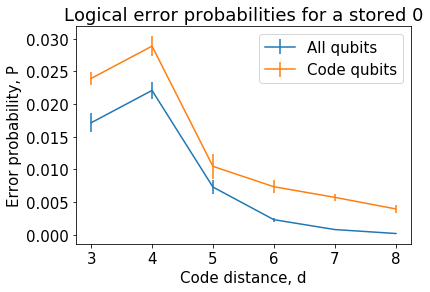

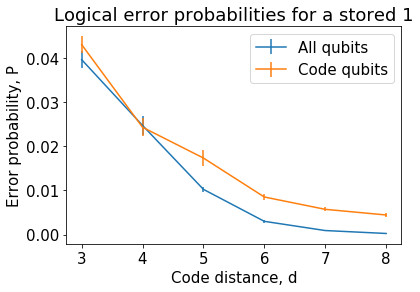

In [16]:
# x axis values are code distances
D = [3,4,5,6,7,8]

# we'll do a separate plot for each encoded value
for bit in [0,1]:

    # now we set up the y axis values, which are error probabilites
    F = []
    f = []
    C = []
    c = []
    for d in D:
        F.append( errorFullMean[d-3][bit] )
        f.append( math.sqrt( errorFullVar[d-3][bit] /2 ) )
        C.append( errorCodeMean[d-3][bit] )
        c.append( math.sqrt( errorCodeVar[d-3][bit] /2 ) )

    # and then we plot and label
    
    plt.errorbar(D, F, yerr= f, label="All qubits")
    plt.errorbar(D, C, yerr= c, label="Code qubits")

    plt.legend(loc='upper right')
    
    plt.xlabel('Code distance, d')
    plt.ylabel('Error probability, P')
    
    plt.title('Logical error probabilities for a stored ' + str(bit))
    
    plt.show()

Here we plot the results for the single qubits.

For each code, the single qubit memory was located in the qubit next to the code. The x axis in this plot will therefore be the qubit address. For the *d=3* code, this address is *0*. However, due to the cylic nature of the adress labelling on the chip, we will refer to this as *16*.

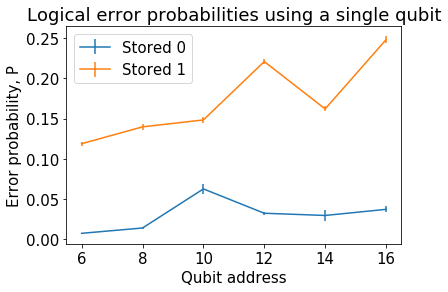

In [17]:
# no need for comments here, since it is as before

Q = [16,14,12,10,8,6]

S = [[],[]]
s = [[],[]]
for bit in[0,1]:

    for d in D:
    
        S[bit].append( errorSingleMean[d-3][bit] )
        s[bit].append( math.sqrt( errorSingleVar[d-3][bit] /2 ) )
        
    plt.errorbar(Q, S[bit], yerr= s[bit], label="Stored "+str(bit) )


plt.legend(loc='upper left')

plt.xlabel('Qubit address')
plt.ylabel('Error probability, P')

plt.title('Logical error probabilities using a single qubit')

plt.show()